# Neuro-TabPFN (Debug Mini-Pipeline)
 - ISLES'24 -> VAE (Z) -> Mock InterSynth -> TabICL/Do-PFN
 - Objetivo causal: CATE  ≜  E[ Y|do(T=1),Z=z] - E[ Y|do(T=0),Z=z]

Este notebook implementa el pipeline completo para predecir outcomes de pacientes con stroke usando:

1. **ISLES'24**: Dataset de imágenes cerebrales 3D (máscaras de lesiones)
2. **VAE**: Comprime las imágenes 3D a vectores latentes
3. **TabPFN**: Predice outcomes clínicos
   
Orden: Config → Carga/EDA → VAE → Latentes → Mock InterSynth → TabPFN/TabICL/Do-Loss → Métricas → Guardado.

## PARTE 0: Set up inicial

### Instalación de Dependencias

In [1]:
import os
import sys

os.environ["HF_DATASETS_CACHE"] = r"D:\hf-datasets-cache" 

ROOT = "H:/My Drive/Debbuging Neuro"

os.chdir(ROOT)
print(sys.executable)

C:\ProgramData\anaconda3\envs\debugging\python.exe


In [3]:
%%capture
!pip install -r requirements.txt

In [16]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt

# MONAI spacing-aware transforms
from monai.transforms import Spacing
from monai.data import MetaTensor

from scipy.ndimage import zoom
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

### Configuración

In [10]:
def set_seeds(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)
set_seeds(42)

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Device:", device)

Device: cpu


In [8]:
class Config:
    """Configuración del pipeline"""
    HF_DATASET = "hugging-science/isles24-stroke"
    N_CASES = 149
    TARGET_SHAPE = (96, 112, 96)  # Matches MNI aspect ratio
    TARGET_SPACING = (2.0, 2.0, 2.0)  # 2mm isotropic (standard MNI resolution)
    LATENT_DIM = 50
    VAE_EPOCHS = 30
    VAE_BATCH_SIZE = 4
    VAE_LR = 1e-4

    # SCM / causal
    SCM_EFFECT = 2.0
    SCM_WEIGHT_Z = 1.5
    SYN_BATCH = 8
    SYN_SEQ = 64

    # TabICL
    D_MODEL = 128
    N_LAYERS = 4
    N_HEAD = 4
    LR_TABICL = 1e-3

cfg = Config()    

# PARTE 0: ISLES DATASET INSPECTION

 Loading ISLES'24 stream...


Resolving data files:   0%|          | 0/149 [00:00<?, ?it/s]


 INSPECTING FIRST 3 SAMPLES
------------------------------------------------------------
 sub-stroke0001
    Shape: (512, 595, 75)
    Values: [0. 1.] (Should be 0. and 1. for masks)
    Affine/Spacing Info: [[-4.68750000e-01 -0.00000000e+00  0.00000000e+00  1.20000000e+02]
 [-0.00000000e+00  4.52777714e-01 -5.17637968e-01 -2.16447571e+02]
 [ 0.00000000e+00  1.21321395e-01  1.93185163e+00 -2.01136841e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


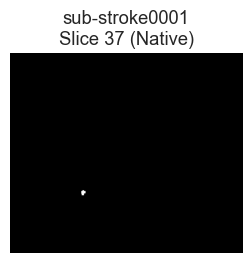

------------------------------------------------------------
 sub-stroke0002
    Shape: (512, 605, 75)
    Values: [0. 1.] (Should be 0. and 1. for masks)
    Affine/Spacing Info: [[-5.41015625e-01  0.00000000e+00  0.00000000e+00  1.26588997e+02]
 [ 0.00000000e+00  5.11540321e-01 -6.51136330e-01 -2.26156067e+02]
 [ 0.00000000e+00  1.76137464e-01  1.89103714e+00 -2.33005447e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


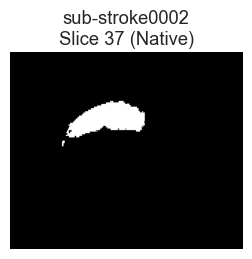

------------------------------------------------------------
 sub-stroke0003
    Shape: (512, 633, 70)
    Values: [0. 1.] (Should be 0. and 1. for masks)
    Affine/Spacing Info: [[-4.10156250e-01 -0.00000000e+00  0.00000000e+00  9.70199966e+01]
 [-0.00000000e+00  3.85420799e-01 -6.84040189e-01 -1.72771271e+02]
 [ 0.00000000e+00  1.40281677e-01  1.87938523e+00 -1.92425629e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


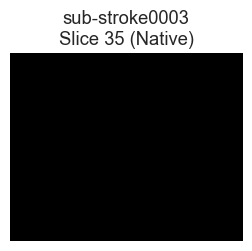

------------------------------------------------------------


In [12]:
# 1. Load a tiny subset from Hugging Face (Stream mode to save RAM)
print(" Loading ISLES'24 stream...")
ds = load_dataset("hugging-science/isles24-stroke", split="train", streaming=True)

def inspect_isles_data(dataset, num_samples=3):
    print(f"\n INSPECTING FIRST {num_samples} SAMPLES")
    print("-" * 60)
    
    # Iterate through the stream
    iterator = iter(dataset)
    for i in range(num_samples):
        sample = next(iterator)
        case_id = sample.get("subject_id", f"Case {i}")
        
        # Extract Mask
        mask_obj = sample.get("lesion_mask")
        
        # Handle HF Image object vs Raw Array
        if hasattr(mask_obj, "get_fdata"): 
            # It's a Nifti object
            mask = mask_obj.get_fdata()
            affine = mask_obj.affine # Important: Contains physical spacing info
        elif hasattr(mask_obj, "numpy"): 
            # It's a PIL/Tensor object
            mask = mask_obj.numpy()
            affine = "Unknown (Raw Array)"
        else:
            mask = np.array(mask_obj)
            affine = "Unknown"

        # Handle 4D (time/channel) vs 3D
        if mask.ndim == 4: mask = mask[..., 0]

        # 2. Extract Statistics
        shape = mask.shape
        unique_vals = np.unique(mask)
        
        print(f" {case_id}")
        print(f"    Shape: {shape}")
        print(f"    Values: {unique_vals} (Should be 0. and 1. for masks)")
        print(f"    Affine/Spacing Info: {affine}")

        # 3. Visualization Check (Middle Slice)
        # We plot the middle slice of the Z-axis to check for distortion
        mid_slice_idx = shape[2] // 2
        mid_slice = mask[:, :, mid_slice_idx]

        plt.figure(figsize=(3, 3))
        plt.imshow(mid_slice, cmap="gray")
        plt.title(f"{case_id}\nSlice {mid_slice_idx} (Native)")
        plt.axis("off")
        plt.show()
        print("-" * 60)

# Run inspection
inspect_isles_data(ds)

## PARTE 1: CARGA Y EXPLORACIÓN DE DATOS

ISLES'24 contiene imágenes médicas de **149 pacientes con stroke (derrame cerebral)**:

| Tipo de Dato | Descripción | Formato |
|--------------|-------------|---------|
| **Máscaras de lesión** | Imagen 3D binaria que muestra dónde está la lesión | NIfTI (64×64×64 voxels) |
| **CT/MRI** | Imágenes cerebrales completas | NIfTI |
| **Datos clínicos** | Edad, sexo, severidad (NIHSS), outcome (mRS) | Numéricos |

### Nosotros usamos:
- **Input**: Máscaras de lesión 3D → comprimidas a vector de 50 números
- **Target**: mRS a 3 meses (0-6, donde 0=sin síntomas, 6=muerte)

In [18]:
# Initialize MONAI spacing transform (fixes physics/anisotropy)
# Resamples all volumes to 2mm isotropic voxels (standard MNI resolution)
spacing_transform = Spacing(pixdim=cfg.TARGET_SPACING, mode="nearest")

print(f" MONAI Spacing Transform initialized: {cfg.TARGET_SPACING}mm isotropic")

 MONAI Spacing Transform initialized: (2.0, 2.0, 2.0)mm isotropic


In [20]:
def resize_with_pad(image, new_shape):
    """
    Resizes image to fit inside new_shape while maintaining aspect ratio.
    Pads with zeros to fill the remaining space.
    
    CRITICAL: This should only be called AFTER MONAI spacing correction.
    """
    original_shape = np.array(image.shape)
    target_shape = np.array(new_shape)
    
    # Calculate scale needed to fit the longest side
    ratios = target_shape / original_shape
    scale = np.min(ratios)
    new_real_shape = (original_shape * scale).astype(int)
    factors = new_real_shape / original_shape
    
    # Order=0 for binary masks (nearest neighbor)
    resized_img = zoom(image, factors, order=0)
    
    # Pad to reach target_shape
    delta = target_shape - new_real_shape
    pad_width = [(d // 2, d - d // 2) for d in delta]
    padded_img = np.pad(resized_img, pad_width, mode='constant', constant_values=0)
    
    return padded_img

In [22]:
def load_isles_from_hf(n_cases=50, target_shape=(96, 112, 96)):
    """
    Load ISLES data with MONAI spacing-aware preprocessing.
    
    Pipeline:
    1. Load raw data + affine from HuggingFace
    2. MONAI Spacing: resample to isotropic voxels (physics correction)
    3. Aspect-preserving resize + padding to target shape
    
    Returns:
        masks: (N, 1, H, W, D) tensor ready for VAE
        clinical: dict with patient metadata
    """
    ds = load_dataset(cfg.HF_DATASET, split="train", streaming=True)
    masks = []
    clinical = {"subject_id": [], "age": [], "sex": [], "nihss_admission": [], "mrs_3month": []}
    
    print(f" Processing first {n_cases} cases with MONAI spacing...")
    iterator = iter(ds)
    
    for i in range(n_cases):
        try:
            ex = next(iterator)
        except StopIteration:
            break
        
        mask_obj = ex.get("lesion_mask")
        if mask_obj is None:
            continue
        
        # ═══════════════════════════════════════════════════════════
        # STEP 1: Load Data & Affine (spacing metadata)
        # ═══════════════════════════════════════════════════════════
        if hasattr(mask_obj, "get_fdata"):
            raw_data = mask_obj.get_fdata()
            raw_affine = mask_obj.affine
        else:
            raw_data = np.array(mask_obj)
            raw_affine = np.eye(4)  # identity if no affine available
        
        if raw_data.ndim == 4:
            raw_data = raw_data[..., 0]
        
        # ═══════════════════════════════════════════════════════════
        # STEP 2: MONAI Spacing (Physics Correction)
        # CRITICAL FIX: This prevents "pancake brain" distortion
        # ═══════════════════════════════════════════════════════════
        # Add channel dim: (W, H, D) -> (1, W, H, D)
        raw_tensor = MetaTensor(np.expand_dims(raw_data, 0), affine=raw_affine)
        resampled_tensor = spacing_transform(raw_tensor)
        
        # Remove channel dim: (1, W', H', D') -> (W', H', D')
        isotropic_data = resampled_tensor[0].numpy()
        
        # ═══════════════════════════════════════════════════════════
        # STEP 3: Aspect-Preserving Resize + Padding
        # ═══════════════════════════════════════════════════════════
        final_mask = resize_with_pad(isotropic_data, target_shape)
        final_mask = (final_mask > 0.5).astype(np.float32)
        
        masks.append(final_mask)
        
        # Collect clinical metadata
        clinical["subject_id"].append(ex.get("subject_id", f"sub-{i}"))
        clinical["age"].append(ex.get("age"))
        clinical["sex"].append(ex.get("sex"))
        clinical["nihss_admission"].append(ex.get("nihss_admission"))
        clinical["mrs_3month"].append(ex.get("mrs_3month"))
        
        print(f"   Case {i+1}: {raw_data.shape} -> {isotropic_data.shape} -> {final_mask.shape}")
    
    masks = np.array(masks)
    
    # Add channel dim back for VAE training input: (N, 1, 96, 112, 96)
    masks = np.expand_dims(masks, axis=1)
    
    print(f"\n Final Batch Shape: {masks.shape}")
    print(f" Voxel Spacing: {cfg.TARGET_SPACING}mm (isotropic)")
    print(f" Target Shape: {cfg.TARGET_SHAPE}")
    
    return masks, clinical



In [24]:
# Cargar datos
masks, clinical_data = load_isles_from_hf(n_cases=cfg.N_CASES, target_shape=cfg.TARGET_SHAPE)

print("\n" + "="*70)
print(" LOADED DATA SUMMARY")
print("="*70)
print(f"Masks shape: {masks.shape}")
print(f"Data type: {masks.dtype}")
print(f"Value range: [{masks.min():.3f}, {masks.max():.3f}]")
print(f"Patients with mRS outcomes: {sum(x is not None for x in clinical_data['mrs_3month'])}")
print("="*70)

Resolving data files:   0%|          | 0/149 [00:00<?, ?it/s]

 Processing first 149 cases with MONAI spacing...
   Case 1: (512, 595, 75) -> (121, 140, 75) -> (96, 112, 96)
   Case 2: (512, 605, 75) -> (139, 164, 75) -> (96, 112, 96)
   Case 3: (512, 633, 70) -> (106, 131, 70) -> (96, 112, 96)
   Case 4: (512, 587, 69) -> (118, 135, 69) -> (96, 112, 96)
   Case 5: (512, 536, 69) -> (106, 111, 69) -> (96, 112, 96)
   Case 6: (512, 544, 64) -> (106, 112, 64) -> (96, 112, 96)
   Case 7: (512, 585, 69) -> (106, 121, 69) -> (96, 112, 96)
   Case 8: (512, 554, 80) -> (106, 114, 80) -> (96, 112, 96)
   Case 9: (512, 540, 69) -> (122, 128, 69) -> (96, 112, 96)
   Case 10: (512, 603, 79) -> (106, 124, 79) -> (96, 112, 96)
   Case 11: (512, 631, 74) -> (106, 130, 74) -> (96, 112, 96)
   Case 12: (512, 612, 75) -> (106, 126, 75) -> (96, 112, 96)
   Case 13: (512, 597, 74) -> (106, 123, 74) -> (96, 112, 96)
   Case 14: (512, 586, 74) -> (99, 113, 74) -> (96, 112, 96)
   Case 15: (512, 512, 72) -> (101, 101, 72) -> (96, 112, 96)
   Case 16: (512, 610, 80) -> 

### Visualización de datos

Las máscaras son **imágenes 3D binarias** donde:
- **Blanco (1)** = Tejido dañado por el stroke
- **Negro (0)** = Tejido sano

In [30]:
# %% Visualización de 3 casos (cortes + MIP)
def visualize_lesion_mask(mask, subject_id="", slice_idx=None):
    """Visualize 3D lesion mask with orthogonal slices + MIP"""
    # Remove channel dimension if present
    if mask.ndim == 4:
        mask = mask[0]
    
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    
    if slice_idx is None:
        slice_idx = [s // 2 for s in mask.shape]
    
    axes[0].imshow(mask[slice_idx[0], :, :], cmap='hot', vmin=0, vmax=1)
    axes[0].set_title(f'Axial z={slice_idx[0]}')
    
    axes[1].imshow(mask[:, slice_idx[1], :], cmap='hot', vmin=0, vmax=1)
    axes[1].set_title(f'Coronal y={slice_idx[1]}')
    
    axes[2].imshow(mask[:, :, slice_idx[2]], cmap='hot', vmin=0, vmax=1)
    axes[2].set_title(f'Sagital x={slice_idx[2]}')
    
    mip = mask.max(axis=0)
    axes[3].imshow(mip, cmap='hot', vmin=0, vmax=1)
    axes[3].set_title('MIP (Maximum Intensity Projection)')
    
    lesion_volume = mask.sum()
    total_volume = mask.size
    perc = 100 * lesion_volume / total_volume
    
    fig.suptitle(f'Máscara {subject_id} | Voxels: {lesion_volume:.0f} ({perc:.2f}%)', 
                 fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    return lesion_volume


 VISUALIZACIÓN DE MÁSCARAS DE LESIÓN

Paciente sub-stroke0001 | Outcome (mRS): 1.0


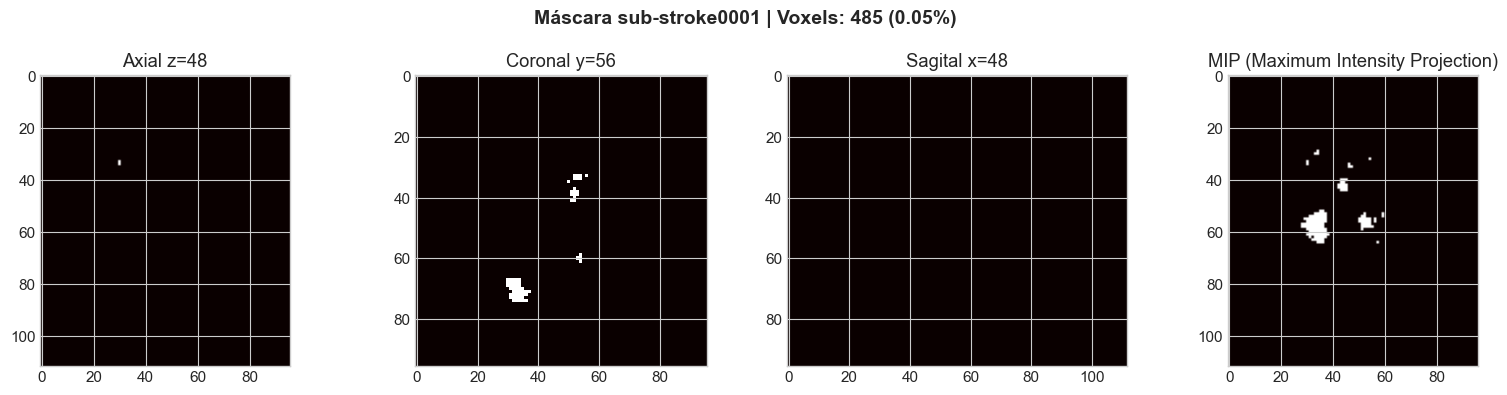


Paciente sub-stroke0002 | Outcome (mRS): 6.0


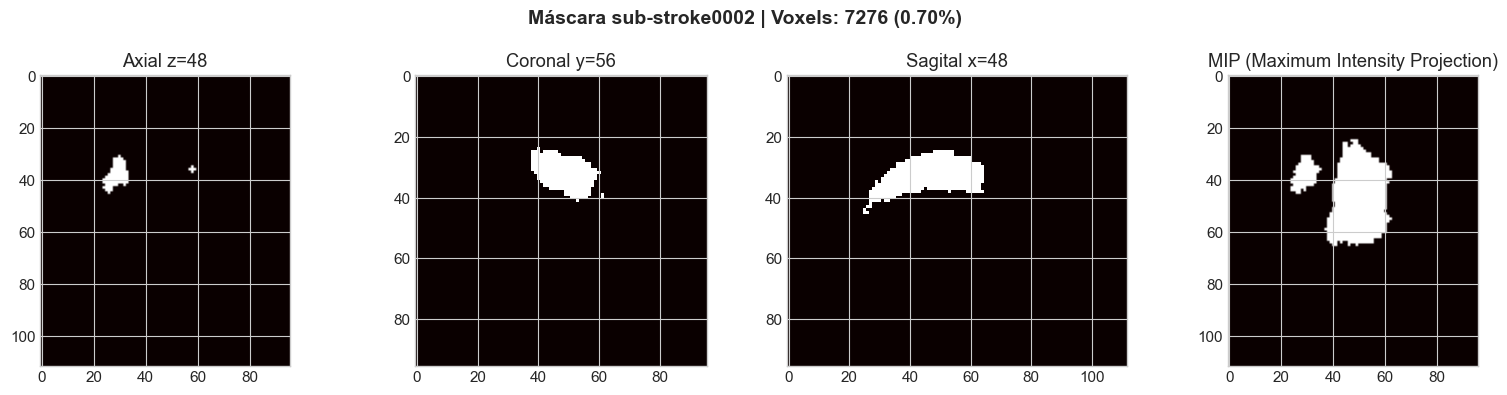


Paciente sub-stroke0003 | Outcome (mRS): 1.0


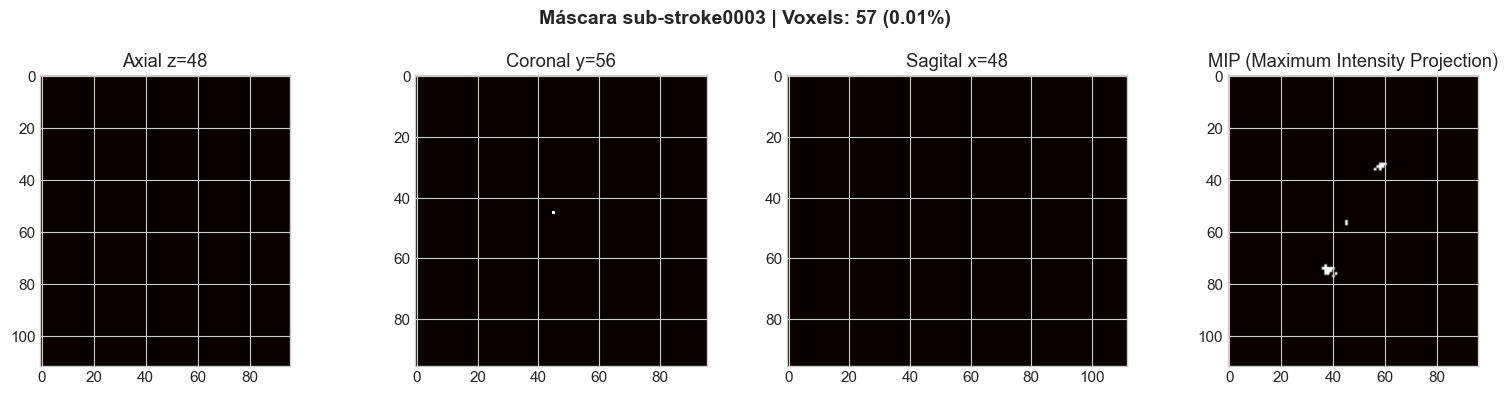

In [32]:
# Visualizar primeros 3 casos
print(" VISUALIZACIÓN DE MÁSCARAS DE LESIÓN")
print("="*60)

for i in range(min(3, len(masks))):
    sid = clinical_data['subject_id'][i]
    mrs = clinical_data['mrs_3month'][i]
    print(f"\nPaciente {sid} | Outcome (mRS): {mrs}")
    visualize_lesion_mask(masks[i], sid)

In [38]:
# Crear DataFrame con datos clínicos
df_clinical = pd.DataFrame(clinical_data)

# Calcular volumen de lesión para cada paciente
df_clinical['lesion_volume'] = [m.sum() for m in masks]
df_clinical['lesion_percentage'] = df_clinical['lesion_volume'] / (64**3) * 100

print(" DATOS CLÍNICOS DE LOS PACIENTES")
print("="*60)
df_clinical.head(10)

print("\n ESTADÍSTICAS DESCRIPTIVAS")
print("="*60)
df_clinical.describe().T

 DATOS CLÍNICOS DE LOS PACIENTES

 ESTADÍSTICAS DESCRIPTIVAS


,count,mean,std,min,25%,50%,75%,max
age,149.0,71.319739,14.609901,29.939726,61.69315,75.983559,82.000000,98.000000
nihss_admission,145.0,10.986207,6.142957,0.000000,6.00000,10.000000,16.000000,24.000000
mrs_3month,129.0,1.914729,2.057877,0.000000,0.00000,1.000000,4.000000,6.000000
lesion_volume,149.0,2847.865723,4043.183594,0.000000,415.00000,982.000000,4033.000000,25435.000000
lesion_percentage,149.0,1.086375,1.542352,0.000000,0.15831,0.374603,1.538467,9.702682



 ESTADÍSTICAS DESCRIPTIVAS


,count,mean,std,min,25%,50%,75%,max
age,149.0,71.319739,14.609901,29.939726,61.69315,75.983559,82.000000,98.000000
nihss_admission,145.0,10.986207,6.142957,0.000000,6.00000,10.000000,16.000000,24.000000
mrs_3month,129.0,1.914729,2.057877,0.000000,0.00000,1.000000,4.000000,6.000000
lesion_volume,149.0,2847.865723,4043.183594,0.000000,415.00000,982.000000,4033.000000,25435.000000
lesion_percentage,149.0,1.086375,1.542352,0.000000,0.15831,0.374603,1.538467,9.702682


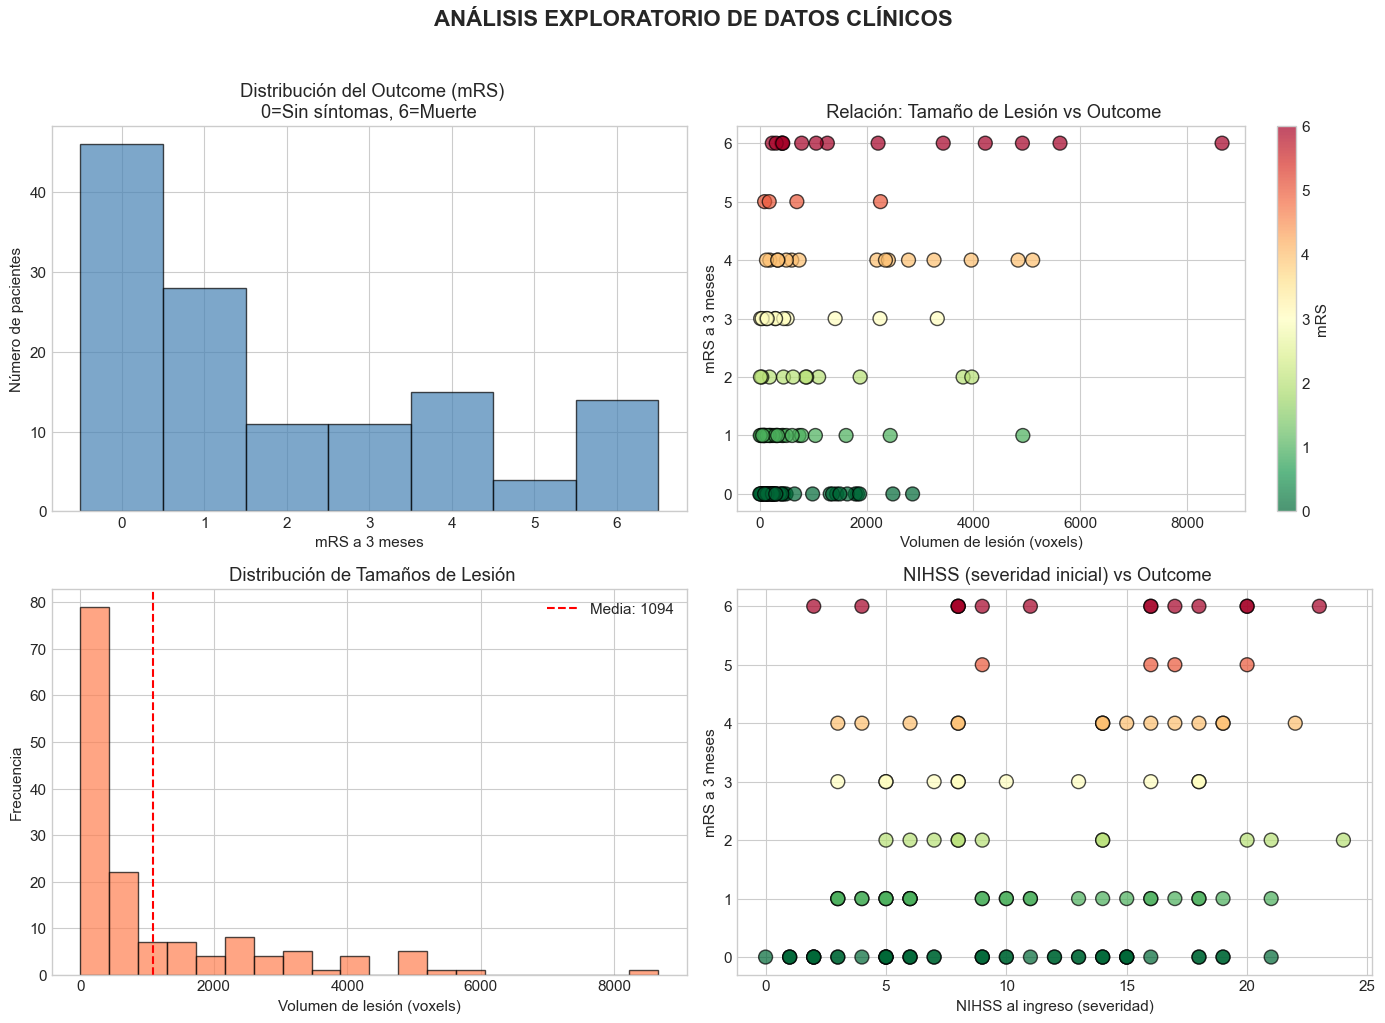

In [19]:
# Visualización de distribuciones
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Distribución de mRS (outcome)
mrs_values = [v for v in clinical_data['mrs_3month'] if v is not None]
colors = plt.cm.RdYlGn_r(np.linspace(0.1, 0.9, 7))
axes[0, 0].hist(mrs_values, bins=range(8), align='left', color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('mRS a 3 meses')
axes[0, 0].set_ylabel('Número de pacientes')
axes[0, 0].set_title(' Distribución del Outcome (mRS)\n0=Sin síntomas, 6=Muerte')
axes[0, 0].set_xticks(range(7))

# 2. Volumen de lesión vs Outcome
valid_idx = [i for i, v in enumerate(clinical_data['mrs_3month']) if v is not None]
volumes = [masks[i].sum() for i in valid_idx]
mrs_valid = [clinical_data['mrs_3month'][i] for i in valid_idx]
scatter = axes[0, 1].scatter(volumes, mrs_valid, c=mrs_valid, cmap='RdYlGn_r', 
                              s=100, alpha=0.7, edgecolors='black')
axes[0, 1].set_xlabel('Volumen de lesión (voxels)')
axes[0, 1].set_ylabel('mRS a 3 meses')
axes[0, 1].set_title(' Relación: Tamaño de Lesión vs Outcome')
plt.colorbar(scatter, ax=axes[0, 1], label='mRS')

# 3. Distribución de volúmenes de lesión
lesion_volumes = [m.sum() for m in masks]
axes[1, 0].hist(lesion_volumes, bins=20, color='coral', edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Volumen de lesión (voxels)')
axes[1, 0].set_ylabel('Frecuencia')
axes[1, 0].set_title(' Distribución de Tamaños de Lesión')
axes[1, 0].axvline(np.mean(lesion_volumes), color='red', linestyle='--', label=f'Media: {np.mean(lesion_volumes):.0f}')
axes[1, 0].legend()

# 4. NIHSS vs Outcome
nihss_valid = [clinical_data['nihss_admission'][i] for i in valid_idx if clinical_data['nihss_admission'][i] is not None]
mrs_nihss = [clinical_data['mrs_3month'][i] for i in valid_idx if clinical_data['nihss_admission'][i] is not None]
if nihss_valid:
    axes[1, 1].scatter(nihss_valid, mrs_nihss, c=mrs_nihss, cmap='RdYlGn_r', 
                       s=100, alpha=0.7, edgecolors='black')
    axes[1, 1].set_xlabel('NIHSS al ingreso (severidad)')
    axes[1, 1].set_ylabel('mRS a 3 meses')
    axes[1, 1].set_title(' NIHSS (severidad inicial) vs Outcome')

plt.suptitle('ANÁLISIS EXPLORATORIO DE DATOS CLÍNICOS', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# VARIATIONAL AUTOENCODER  3D (VAE)

Comprime una imagen 3D de **262,144 voxels** (64×64×64) a un **vector de 50 números**.

```
Máscara 3D [64, 64, 64] → Encoder → Vector Z [50] → Decoder → Reconstrucción [64, 64, 64]
     262,144 valores              50 valores              262,144 valores
```

El vector Z de 50 números captura la "esencia" de la lesión (tamaño, forma, ubicación).

In [21]:
# Preparar datos para entrenamiento: Dataset para VAE
class MaskDataset(Dataset):
    def __init__(self, masks_np):
        self.m = torch.from_numpy(masks_np).float().unsqueeze(1)
    def __len__(self): return len(self.m)
    def __getitem__(self, idx): return self.m[idx]

dataset = MaskDataset(masks)
dataloader = DataLoader(dataset, batch_size=cfg.VAE_BATCH_SIZE, shuffle=True)

In [22]:
# Definición del VAE 3D

class Encoder3D(nn.Module):
    def __init__(self, latent_dim=50):
        super().__init__()
        self.conv1 = nn.Conv3d(1, 32, 4, 2, 1)
        self.conv2 = nn.Conv3d(32, 64, 4, 2, 1)
        self.conv3 = nn.Conv3d(64, 128, 4, 2, 1)
        self.conv4 = nn.Conv3d(128, 256, 4, 2, 1)
        self.bn1, self.bn2, self.bn3, self.bn4 = nn.BatchNorm3d(32), nn.BatchNorm3d(64), nn.BatchNorm3d(128), nn.BatchNorm3d(256)
        self.relu = nn.LeakyReLU(0.2)
        self.fc_mu = nn.Linear(256*4*4*4, latent_dim)
        self.fc_logvar = nn.Linear(256*4*4*4, latent_dim)
    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.relu(self.bn4(self.conv4(x)))
        x = x.view(x.size(0), -1)
        return self.fc_mu(x), self.fc_logvar(x)

class Decoder3D(nn.Module):
    def __init__(self, latent_dim=50):
        super().__init__()
        self.fc = nn.Linear(latent_dim, 256*4*4*4)
        self.deconv1 = nn.ConvTranspose3d(256, 128, 4, 2, 1)
        self.deconv2 = nn.ConvTranspose3d(128, 64, 4, 2, 1)
        self.deconv3 = nn.ConvTranspose3d(64, 32, 4, 2, 1)
        self.deconv4 = nn.ConvTranspose3d(32, 1, 4, 2, 1)
        self.bn1, self.bn2, self.bn3 = nn.BatchNorm3d(128), nn.BatchNorm3d(64), nn.BatchNorm3d(32)
        self.relu = nn.LeakyReLU(0.2)
    def forward(self, z):
        x = self.fc(z).view(-1,256,4,4,4)
        x = self.relu(self.bn1(self.deconv1(x)))
        x = self.relu(self.bn2(self.deconv2(x)))
        x = self.relu(self.bn3(self.deconv3(x)))
        return torch.sigmoid(self.deconv4(x))

class LesionVAE(nn.Module):
    def __init__(self, latent_dim=50):
        super().__init__()
        self.encoder = Encoder3D(latent_dim)
        self.decoder = Decoder3D(latent_dim)
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        return mu + torch.randn_like(std)*std
    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar
    def encode(self, x):
        mu, _ = self.encoder(x)
        return mu

vae = LesionVAE(latent_dim=cfg.LATENT_DIM).to(device)
optimizer_vae = optim.Adam(vae.parameters(), lr=cfg.VAE_LR)

print(" VAE definido")

 VAE definido


In [23]:
# Entrenar VAE
def vae_loss(recon, original, mu, logvar, beta=1.0):
    recon_loss = nn.functional.binary_cross_entropy(recon, original, reduction='sum')
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + beta * kl

losses = []
for epoch in range(cfg.VAE_EPOCHS):
    vae.train(); epoch_loss=0
    for batch in dataloader:
        batch = batch.to(device)
        optimizer_vae.zero_grad()
        recon, mu, logvar = vae(batch)
        loss = vae_loss(recon, batch, mu, logvar)
        loss.backward(); optimizer_vae.step()
        epoch_loss += loss.item()
    avg = epoch_loss / len(dataset)
    losses.append(avg)
    if (epoch+1)%5==0: print(f"Epoch {epoch+1}/{cfg.VAE_EPOCHS} loss {avg:,.0f}")
        
print("-" * 50)
print(" Entrenamiento completado")

Epoch 5/30 loss 64,976
Epoch 10/30 loss 25,687
Epoch 15/30 loss 13,459
Epoch 20/30 loss 8,509
Epoch 25/30 loss 6,102
Epoch 30/30 loss 4,653
--------------------------------------------------
 Entrenamiento completado


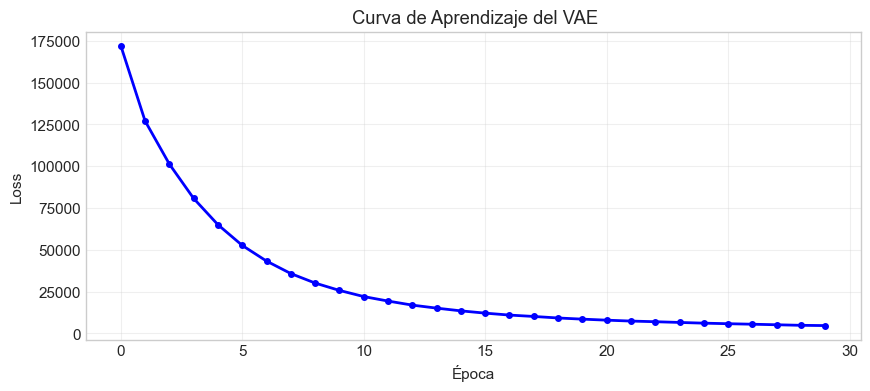

In [24]:
# Visualizar curva de aprendizaje
plt.figure(figsize=(10, 4))
plt.plot(losses, 'b-', linewidth=2, marker='o', markersize=4)
plt.xlabel('Época')
plt.ylabel('Loss')
plt.title(' Curva de Aprendizaje del VAE')
plt.grid(True, alpha=0.3)
plt.show()

## Extraer Vectores Latentes Z

In [26]:
# %% Extraer latentes Z
vae.eval()
with torch.no_grad():
    Z_list=[]
    for batch in DataLoader(dataset, batch_size=cfg.VAE_BATCH_SIZE):
        z = vae.encode(batch.to(device)).cpu()
        Z_list.append(z)
    Z = torch.cat(Z_list, dim=0).numpy()
print("Z shape:", Z.shape)

Z shape: (149, 50)


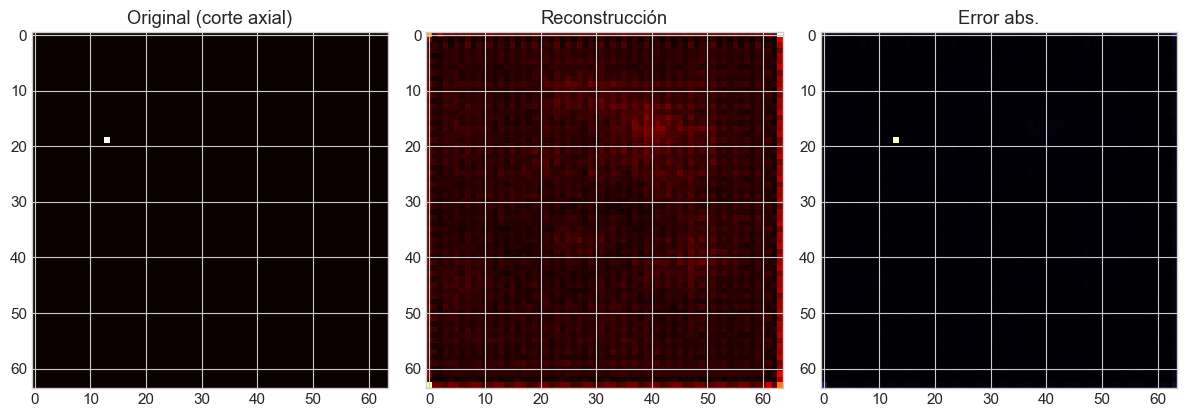

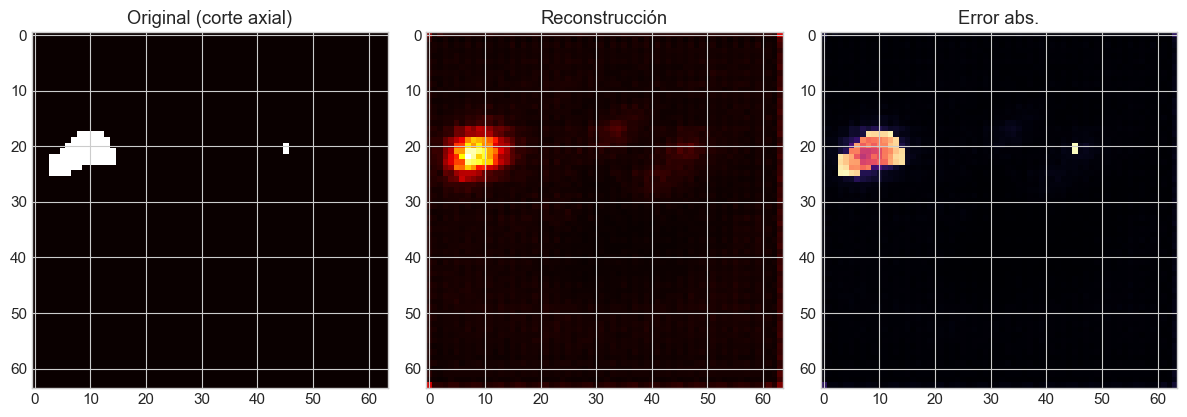

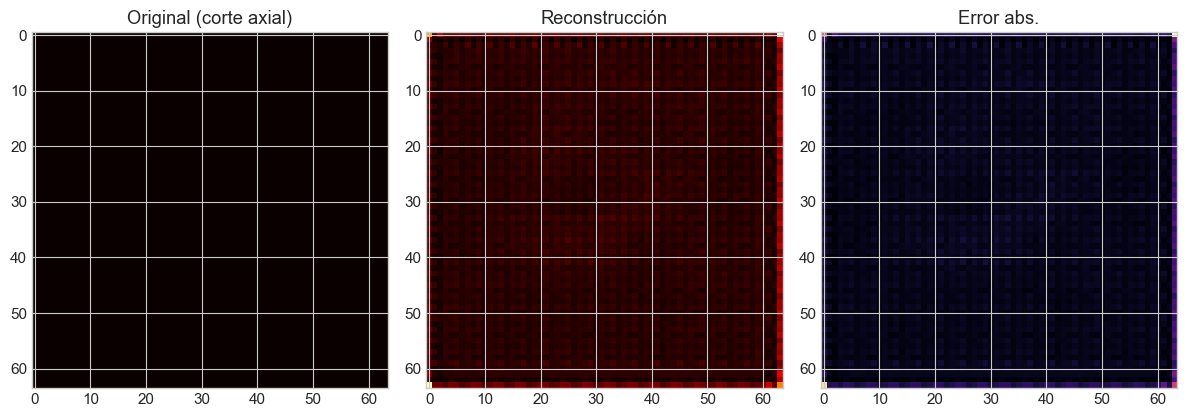

In [27]:
# %% Visualizar reconstrucciones del VAE
def visualize_reconstruction(vae, dataset, num=3):
    vae.eval()
    with torch.no_grad():
        for i in range(min(num, len(dataset))):
            x = dataset[i].unsqueeze(0).to(device)  # [1,1,64,64,64]
            recon, _, _ = vae(x)
            x_np = x.cpu().numpy()[0,0]
            r_np = recon.cpu().numpy()[0,0]
            fig, axes = plt.subplots(1, 3, figsize=(12,4))
            mid = x_np.shape[0]//2
            axes[0].imshow(x_np[mid], cmap="hot"); axes[0].set_title("Original (corte axial)")
            axes[1].imshow(r_np[mid], cmap="hot"); axes[1].set_title("Reconstrucción")
            diff = np.abs(x_np - r_np)
            axes[2].imshow(diff[mid], cmap="magma"); axes[2].set_title("Error abs.")
            plt.tight_layout(); plt.show()

visualize_reconstruction(vae, dataset, num=3)

In [28]:
# Mock InterSynth: mapa aleatorio y Y_mock por dot product
torch.manual_seed(0)
weight_map = torch.randn(*cfg.TARGET_SHAPE)
Y_mock = (torch.from_numpy(masks).float() * weight_map).sum(dim=(1,2,3)).numpy()
Y_mock = (Y_mock - Y_mock.mean()) / (Y_mock.std() + 1e-6)
print("Y_mock:", Y_mock.shape, "mean", Y_mock.mean(), "std", Y_mock.std())

Y_mock: (149,) mean -3.2002494e-09 std 0.9999999


In [29]:
# %% Conexión híbrida: genera T,Y_scm sobre Z reales
Z_real_torch = torch.from_numpy(Z).float().to(device)
logits_t = Z_real_torch[:,0]*2.0 + torch.randn_like(Z_real_torch[:,0])
prob_t = torch.sigmoid(logits_t)
T_real = torch.bernoulli(prob_t).unsqueeze(-1)          # [N,1]
Y_real_scm = cfg.SCM_EFFECT * T_real - cfg.SCM_WEIGHT_Z * Z_real_torch[:,0:1]  # [N,1]

# MiniNeuroTabPFN 

In [31]:
# %% MiniNeuroTabPFN (usa Y en contexto)
class MiniNeuroTabPFN(nn.Module):
    def __init__(self, n_features=50, d_model=128, n_layers=4, nhead=4, dropout=0.0):
        super().__init__()
        self.feature_encoder = nn.Linear(n_features + 2, d_model)  # Z + T + Y
        enc_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True, dropout=dropout)
        self.transformer = nn.TransformerEncoder(enc_layer, num_layers=n_layers)
        self.head = nn.Linear(d_model, 1)
    def forward(self, z, t, y_masked):
        x = torch.cat([z, t, y_masked], dim=-1)   # [B,S,F+2]
        emb = self.feature_encoder(x)
        ctx = self.transformer(emb)
        return self.head(ctx)

model = MiniNeuroTabPFN(n_features=cfg.LATENT_DIM, d_model=cfg.D_MODEL,
                        n_layers=cfg.N_LAYERS, nhead=cfg.N_HEAD).to(device)
opt = optim.Adam(model.parameters(), lr=cfg.LR_TABICL)
loss_fn = nn.MSELoss()


# Generador SCM con Confounding

In [33]:
# %% Utils SCM sintético (para training y PEHE)
def make_synth_batch(batch_size=cfg.SYN_BATCH, seq_len=cfg.SYN_SEQ, n_features=cfg.LATENT_DIM, on_real_Z=None):
    if on_real_Z is None:
        z = torch.randn(batch_size, seq_len, n_features, device=device)
    else:
        N = on_real_Z.shape[0]
        idx = torch.randint(0, N, (batch_size*seq_len,), device=device)
        z = on_real_Z[idx].view(batch_size, seq_len, n_features)
    logits_t = z[:,:,0]*2.0 + torch.randn_like(z[:,:,0])
    prob_t = torch.sigmoid(logits_t)
    t = torch.bernoulli(prob_t).unsqueeze(-1)
    y = cfg.SCM_EFFECT * t - cfg.SCM_WEIGHT_Z * z[:,:,0:1]
    return z, t, y

# Do-Loss Training

In [35]:
def train_do_step(z, t, y_true, steps=1):
    model.train()
    for _ in range(steps):
        B,S,F = z.shape
        Z_ctx, Z_q = z[:,:-1,:], z[:,-1:,:]
        T_ctx = t[:,:-1,:]
        Y_ctx = y_true[:,:-1,:]
        T_q = torch.bernoulli(torch.full_like(t[:,-1:,:], 0.5))
        Y_q_true = cfg.SCM_EFFECT * T_q - cfg.SCM_WEIGHT_Z * Z_q[:,:,0:1]
        Z_in = torch.cat([Z_ctx, Z_q], dim=1)
        T_in = torch.cat([T_ctx, T_q], dim=1)
        Y_in = torch.cat([Y_ctx, torch.zeros_like(Y_q_true)], dim=1)
        pred = model(Z_in, T_in, Y_in)
        pred_q = pred[:,-1:,:]
        loss = loss_fn(pred_q, Y_q_true)
        opt.zero_grad(); loss.backward(); opt.step()
    return loss.item()


Do-step 20: loss 1.6616
Do-step 40: loss 2.9813
Do-step 60: loss 2.6884
Do-step 80: loss 2.8462
Do-step 100: loss 2.0618
Do-step 120: loss 2.2988
Do-step 140: loss 2.7956
Do-step 160: loss 1.6364
Do-step 180: loss 1.7161
Do-step 200: loss 4.3935


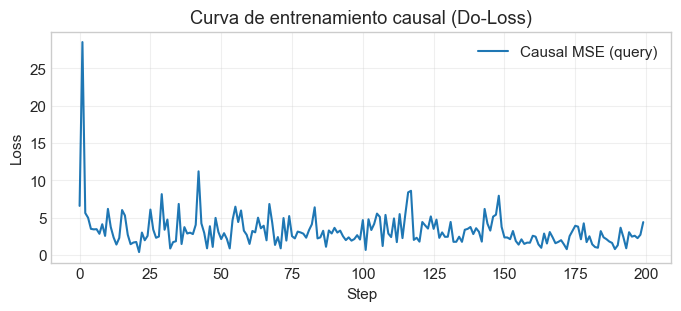

In [36]:
loss_causal=[]
for step in range(200):
    z,t,y = make_synth_batch()
    loss = train_do_step(z,t,y,steps=1)
    loss_causal.append(loss)
    if (step+1)%20==0:
        print(f"Do-step {step+1}: loss {loss:.4f}")

plt.figure(figsize=(8,3))
plt.plot(loss_causal, label='Causal MSE (query)')
plt.title('Curva de entrenamiento causal (Do-Loss)')
plt.xlabel('Step'); plt.ylabel('Loss'); plt.grid(True, alpha=0.3); plt.legend(); plt.show()

# Benchmark CATE

In [38]:
# %% Benchmark CATE sintético (~2.0)
@torch.no_grad()
def predict_cate(model, z_base, t_base):
    z_new = torch.randn_like(z_base[:, :1, :])
    def pred_for(tval):
        Zin = torch.cat([z_base, z_new], 1)
        Tin = torch.cat([t_base, torch.full_like(t_base[:,:1,:], tval)], 1)
        Yin = torch.zeros_like(Tin)
        out = model(Zin, Tin, Yin)
        return out[:,-1,0]
    y1 = pred_for(1.0); y0 = pred_for(0.0)
    return (y1 - y0).mean().item()

z_b,t_b,_ = make_synth_batch(batch_size=4)
cate_hat = predict_cate(model, z_b, t_b)
print(f"CATE pred (synth): {cate_hat:.3f} (esperado ~2.0)")

CATE pred (synth): 0.394 (esperado ~2.0)


# PEHE Metric

In [40]:
# %% PEHE en sintético
@torch.no_grad()
def pehe(model, batches=20):
    errs=[]
    for _ in range(batches):
        z,t,y = make_synth_batch()
        z_new = torch.randn_like(z[:,:1,:])
        Zin = torch.cat([z, z_new], 1)
        Tin1 = torch.cat([t, torch.ones_like(t[:,:1,:])], 1)
        Tin0 = torch.cat([t, torch.zeros_like(t[:,:1,:])], 1)
        Yin = torch.zeros_like(Tin1)
        y1 = model(Zin, Tin1, Yin)[:,-1,0]
        y0 = model(Zin, Tin0, Yin)[:,-1,0]
        tau_hat = y1 - y0
        tau_true = torch.full_like(tau_hat, cfg.SCM_EFFECT)
        errs.append(((tau_hat - tau_true)**2).mean().sqrt().item())
    return np.mean(errs)

pehe_s = pehe(model, batches=20)
print("PEHE (synth):", pehe_s)

PEHE (synth): 1.8390076994895934


In [41]:
# %% Baseline ingenuo (regresión lineal) en Z -> Y_mock (no causal)
lin = LinearRegression().fit(Z, Y_mock)
pred_lin = lin.predict(Z)
print("Baseline Lin MSE:", mean_squared_error(Y_mock, pred_lin),
      "R2:", r2_score(Y_mock, pred_lin))

Baseline Lin MSE: 0.30940037965774536 R2: 0.6905995607376099


In [42]:
# Conexión con Z Reales

CATE real (latentes ISLES) mean: 0.29818225 std: 0.36964208


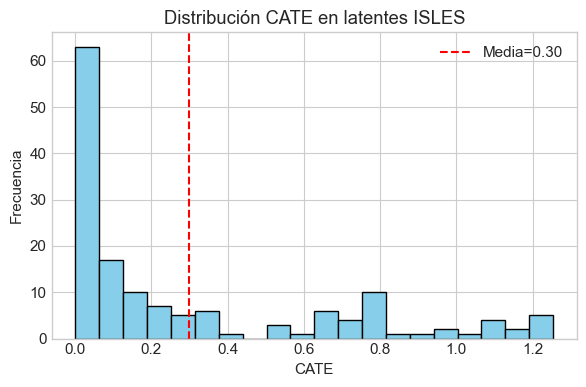

In [43]:
# %% CATE en latentes REALES (ISLES) con el modelo causal entrenado
@torch.no_grad()
def predict_cate_real(model, Z_real_np, batch_size=16):
    model.eval()
    Zr = torch.from_numpy(Z_real_np).float().to(device)  # Z reales del VAE
    N, F = Zr.shape
    cates = []
    for i in range(0, N, batch_size):
        z_batch = Zr[i:i+batch_size]                     # [B,F]
        # Tratamiento observacional sintético (si no tienes T_real)
        logits_t = z_batch[:,0]*2.0 + torch.randn_like(z_batch[:,0])
        prob_t = torch.sigmoid(logits_t)
        t_obs = torch.bernoulli(prob_t).unsqueeze(-1)    # [B,1]

        # Secuencia mínima (contexto + query)
        z_seq = torch.stack([z_batch, z_batch], dim=1)   # [B,2,F]
        t_ctx = t_obs.unsqueeze(1)                       # [B,1,1]
        t_q1 = torch.ones_like(t_ctx)                    # do(T=1)
        t_q0 = torch.zeros_like(t_ctx)                   # do(T=0)

        def run_with(t_query):
            Zin = torch.cat([z_seq[:,0:1,:], z_seq[:,1:2,:]], dim=1)
            Tin = torch.cat([t_ctx, t_query], dim=1)
            Yin = torch.zeros_like(Tin)
            out = model(Zin, Tin, Yin)
            return out[:, -1, 0]

        y1 = run_with(t_q1)
        y0 = run_with(t_q0)
        cates.append((y1 - y0).cpu())
    return torch.cat(cates, dim=0).numpy()

cate_real = predict_cate_real(model, Z)
print("CATE real (latentes ISLES) mean:", cate_real.mean(), "std:", cate_real.std())
plt.figure(figsize=(6,4))
plt.hist(cate_real, bins=20, color='skyblue', edgecolor='k')
plt.axvline(cate_real.mean(), color='r', linestyle='--', label=f"Media={cate_real.mean():.2f}")
plt.title("Distribución CATE en latentes ISLES")
plt.xlabel("CATE"); plt.ylabel("Frecuencia"); plt.legend(); plt.tight_layout(); plt.show()

In [44]:
# %% Evaluación híbrida (Z reales + SCM labels)
@torch.no_grad()
def eval_hybrid(model, Z_real_np, batches=10):
    Zr = torch.from_numpy(Z_real_np).float().to(device)
    errs=[]
    for _ in range(batches):
        z,t,y = make_synth_batch(on_real_Z=Zr)
        z_new = torch.randn_like(z[:,:1,:])
        Zin = torch.cat([z, z_new], 1)
        Tin1 = torch.cat([t, torch.ones_like(t[:,:1,:])], 1)
        Tin0 = torch.cat([t, torch.zeros_like(t[:,:1,:])], 1)
        Yin = torch.zeros_like(Tin1)
        y1 = model(Zin, Tin1, Yin)[:,-1,0]
        y0 = model(Zin, Tin0, Yin)[:,-1,0]
        tau_hat = y1 - y0
        tau_true = torch.full_like(tau_hat, cfg.SCM_EFFECT)
        errs.append(((tau_hat - tau_true)**2).mean().sqrt().item())
    return np.mean(errs)

pehe_h = eval_hybrid(model, Z, batches=10)
print("PEHE híbrido (Z reales + SCM):", pehe_h)

PEHE híbrido (Z reales + SCM): 1.7975991010665893


In [45]:
# Comparación observacional vs causal (Do-PFN)

with torch.no_grad():
    # Batch sintético con el mismo SCM
    z_batch, t_batch, y_batch = make_synth_batch(
        batch_size=cfg.SYN_BATCH,
        seq_len=cfg.SYN_SEQ,
        n_features=cfg.LATENT_DIM
    )
    t_flat = t_batch.flatten()
    y_flat = y_batch.flatten()

    obs_effect = y_flat[t_flat == 1].mean() - y_flat[t_flat == 0].mean()  # sesgado por Z
    causal_effect = predict_cate(model, z_batch, t_batch)                # do-effect ~2.0

print(f"Efecto OBSERVACIONAL (sesgado): {obs_effect:.3f}")
print(f"Efecto CAUSAL (Do-PFN):        {causal_effect:.3f}")

Efecto OBSERVACIONAL (sesgado): 0.267
Efecto CAUSAL (Do-PFN):        0.240


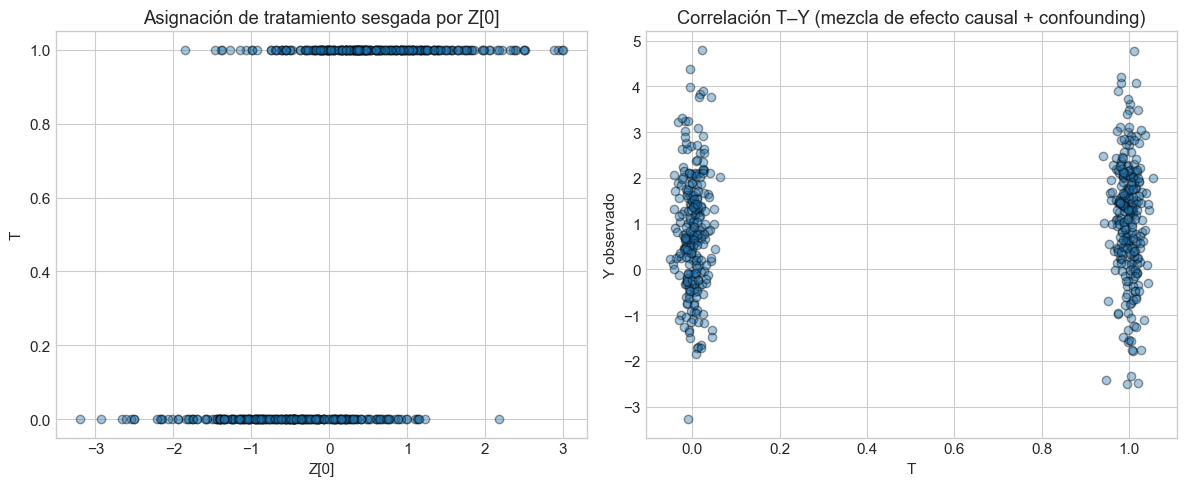

In [46]:
# Visualización del confounding: Z→T y T↔Y (espurio vs causal)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

z0 = z_batch[:, :, 0].flatten().cpu()
t_flat = t_flat.cpu()
y_flat = y_flat.cpu()

# Z[0] → T (propensión confounded)
axes[0].scatter(z0, t_flat, alpha=0.4, edgecolors="k")
axes[0].set_xlabel("Z[0]")
axes[0].set_ylabel("T")
axes[0].set_title("Asignación de tratamiento sesgada por Z[0]")

# T ↔ Y (correlación espuria)
axes[1].scatter(t_flat + 0.02 * torch.randn_like(t_flat), y_flat, alpha=0.4, edgecolors="k")
axes[1].set_xlabel("T")
axes[1].set_ylabel("Y observado")
axes[1].set_title("Correlación T–Y (mezcla de efecto causal + confounding)")

plt.tight_layout()
plt.show()

In [47]:

try:
    from causalml.dataset import synthetic_data  
    X, y, t, b, e = synthetic_data(mode=1, n=2000, p=20, sigma=1.0) 

    # Normaliza shapes para reutilizar el modelo (Z = features)
    Z_ext = torch.from_numpy(X).float().to(device)
    T_ext = torch.from_numpy(t).float().unsqueeze(-1).to(device)
    # Outcome observado
    Y_ext = torch.from_numpy(y).float().unsqueeze(-1).to(device)

    def predict_cate_tab(model, Z_tensor, T_tensor, batch_size=64):
        preds = []
        with torch.no_grad():
            for i in range(0, Z_tensor.size(0), batch_size):
                zb = Z_tensor[i:i+batch_size].unsqueeze(1)          # [B,1,F]
                tb = T_tensor[i:i+batch_size].unsqueeze(1)          # [B,1,1]
                # dummy Y (mascarado en forward), usa ceros
                y_masked = torch.zeros_like(tb).to(device)
                # do(T=1) y do(T=0)
                y1 = model(zb, torch.ones_like(tb), y_masked)
                y0 = model(zb, torch.zeros_like(tb), y_masked)
                preds.append((y1 - y0).cpu())
        return torch.cat(preds, dim=0)

    tau_hat_ext = predict_cate_tab(model, Z_ext, T_ext)
    print(f"CATE medio (externo): {tau_hat_ext.mean().item():.3f}")
except ImportError as e:
    print(" RealCause/ACIC loader no disponible. Instala el dataset y ajusta el stub.")
except Exception as e:
    print(" Benchmark externo saltado por error:", e)

 RealCause/ACIC loader no disponible. Instala el dataset y ajusta el stub.


In [48]:
# %% Guardar artefactos
os.makedirs("Data", exist_ok=True)
np.save("Data/latents.npy", Z)
np.save("Data/y_mock.npy", Y_mock)
torch.save(vae.state_dict(), "Data/vae_checkpoint.pt")
torch.save(model.state_dict(), "Data/tabicl_mini.pt")
print("Artefactos guardados.")

Artefactos guardados.
